<a href="https://colab.research.google.com/github/sushirito/Hg2/blob/main/2D_Pore_Reaction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install deepxde

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.7/190.7 kB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.8/107.8 kB 7.1 MB/s eta 0:00:00


In [ ]:
import deepxde as dde
import numpy as np
import matplotlib.pyplot as plt

D = 1.0
k = 0.1
alpha = 1.0

outer = dde.geometry.Rectangle(xmin=[0, 0], xmax=[1, 1])
inclusion = dde.geometry.Disk(center=[0.5, 0.5], radius=0.2)
fluid_domain = outer - inclusion

def robin_func(x, u):
    return k * (alpha - u)

def boundary_solid(x, on_boundary):
    return on_boundary and inclusion.on_boundary(x)

robin_bc = dde.icbc.RobinBC(
    fluid_domain,
    func=robin_func,
    on_boundary=boundary_solid
)


def pde(x, u):
    d2u_dx2 = dde.grad.hessian(u, x, i=0, j=0)
    d2u_dy2 = dde.grad.hessian(u, x, i=1, j=1)
    return D * (d2u_dx2 + d2u_dy2)  # grad^2(u) = 0

data = dde.data.PDE(
    fluid_domain,
    pde,
    [robin_bc],
    num_domain=1000,
    num_boundary=100,
    solution=None,
    num_test=200,
)

net = dde.nn.FNN(
    [2] + [50] * 4 + [1],
    "tanh",
    "Glorot normal",
)

# 5. Model Compilation
model = dde.Model(data, net)
model.compile("adam", lr=0.001)


losshistory, train_state = model.train(
    iterations=10000,
)

dde.saveplot(losshistory, train_state, issave=True, isplot=True)

#New

Compiling model...
Building feed-forward neural network...
'build' took 0.058519 s

'compile' took 0.535646 s

Training model...

Step      Train loss                        Test loss                         Test metric
0         [1.58e-03, 2.50e-01, 1.34e-03]    [1.53e-03, 2.50e-01, 1.34e-03]    []  
1000      [1.58e-06, 7.57e-11, 9.13e-12]    [8.81e-07, 7.57e-11, 9.13e-12]    []  
2000      [2.13e-07, 1.03e-12, 1.66e-10]    [1.47e-07, 1.03e-12, 1.66e-10]    []  
3000      [4.45e-08, 4.30e-11, 1.16e-08]    [1.88e-08, 4.30e-11, 1.16e-08]    []  
4000      [1.03e-08, 3.20e-14, 8.53e-12]    [8.05e-09, 3.20e-14, 8.53e-12]    []  
5000      [6.82e-09, 8.88e-16, 1.90e-12]    [5.58e-09, 8.88e-16, 1.90e-12]    []  

Best model at step 5000:
  train loss: 6.82e-09
  test loss: 5.58e-09
  test metric: []

'train' took 7.566113 s

Saving loss history to /content/loss.dat ...
Saving training data to /content/train.dat ...
Saving test data to /content/test.dat ...


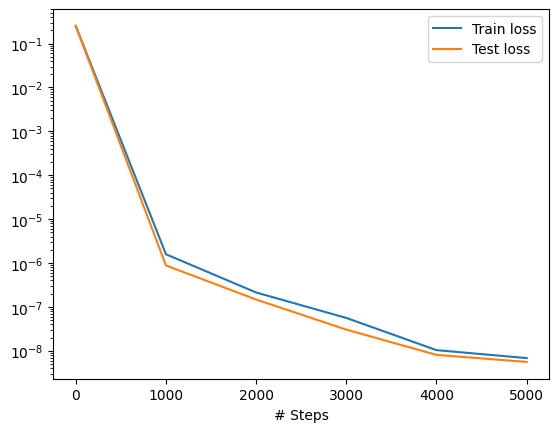

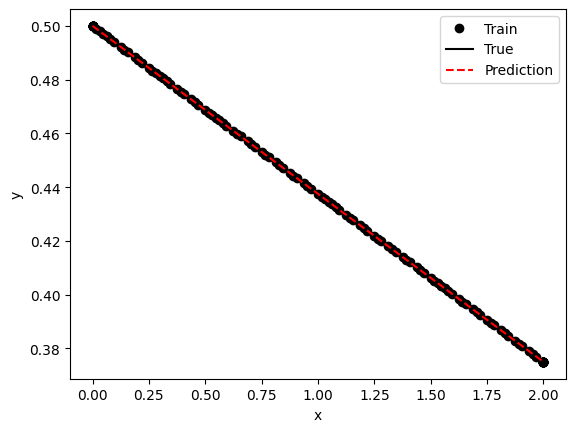

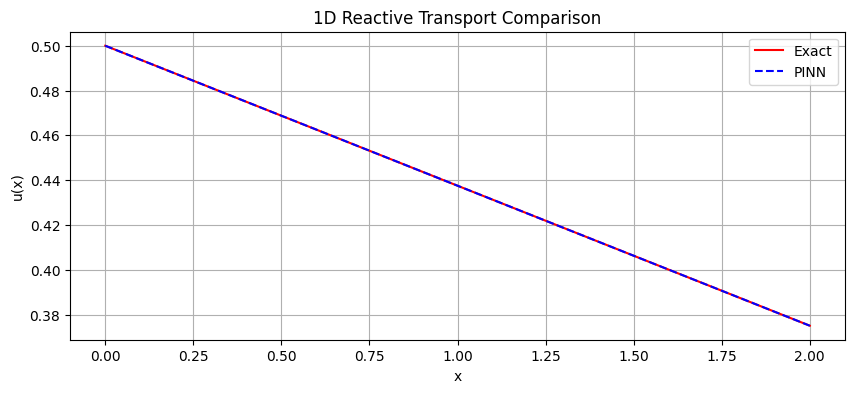

In [9]:
import deepxde as dde
import numpy as np
import matplotlib.pyplot as plt

D = 1.0
k = 0.1
alpha = 1.0
u0 = 0.5
L = 2.0

# 1D domain
geom = dde.geometry.Interval(0, L)

def robin_func(inputs, outputs, X):
    du_dx = dde.grad.jacobian(outputs, inputs)
    return -D * du_dx - k * (alpha - outputs)

def boundary_right(x, on_boundary):
    return on_boundary and np.isclose(x[0], L)

bc_right = dde.icbc.OperatorBC(geom, robin_func, boundary_right)


# Dirichlet BC at left boundary
bc_left = dde.icbc.DirichletBC(geom, lambda x: u0, lambda x, on_boundary: on_boundary and np.isclose(x[0], 0))

# PDE definition
def pde(x, u):
    du_xx = dde.grad.hessian(u, x)
    return D * du_xx

# Analytical solution
def exact_solution(x):
    return u0 + (k*(alpha - u0)/(k*L - D))*x

data = dde.data.PDE(
    geom,
    pde,
    [bc_left, bc_right],
    num_domain=100,
    num_boundary=20,
    solution=exact_solution,
    num_test=100,
)

net = dde.nn.FNN([1] + [50]*3 + [1], "tanh", "Glorot normal")
model = dde.Model(data, net)
model.compile("adam", lr=0.001)

# Training
losshistory, train_state = model.train(iterations=5000)

dde.saveplot(losshistory, train_state, issave=True, isplot=True)

# Plot results
x = np.linspace(0, L, 100).reshape(-1, 1)
u_pred = model.predict(x)
u_exact = exact_solution(x)

plt.figure(figsize=(10,4))
plt.plot(x, u_exact, '-r', label='Exact')
plt.plot(x, u_pred, '--b', label='PINN')
plt.xlabel('x'), plt.ylabel('u(x)')
plt.title('1D Reactive Transport Comparison')
plt.legend(), plt.grid(True)
plt.show()

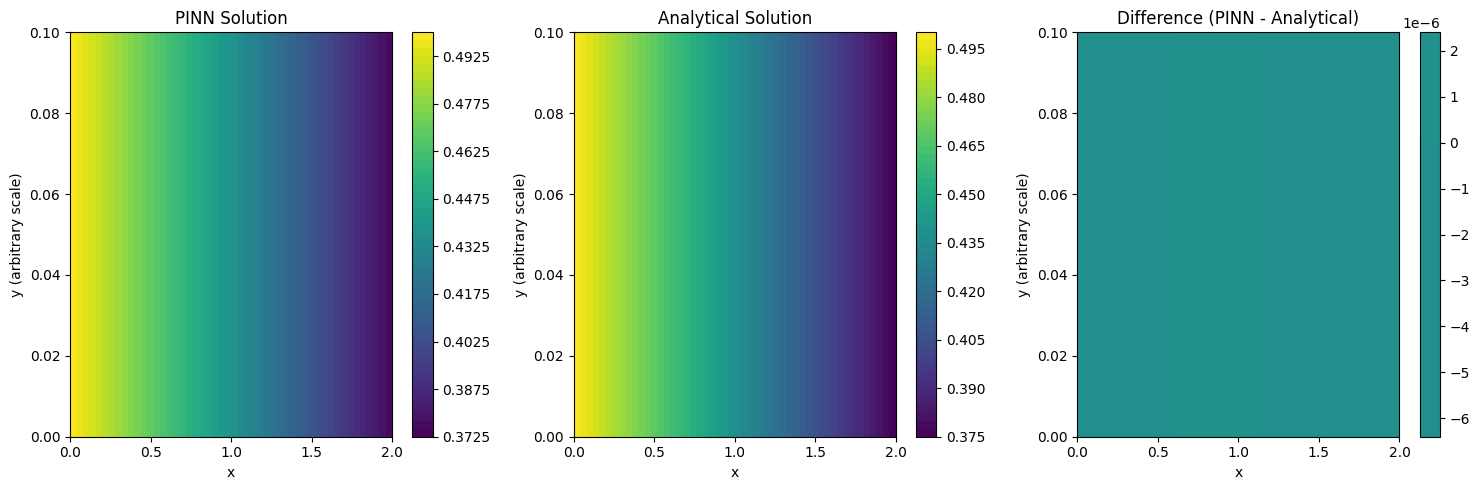

In [13]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
D = 1.0
k = 0.1
alpha = 1.0
u0 = 0.5
L = 2.0

# Generate grid points
x = np.linspace(0, L, 100)
y = np.linspace(0, 0.1, 20)
X, Y = np.meshgrid(x, y)

# Get PINN predictions (1D solution)
pinn_1d = model.predict(x.reshape(-1, 1)).flatten()  # Shape (100,)

# Analytical solution
def analytical(x):
    return u0 + (k*(alpha - u0)/(k*L - D))*x
analytic_1d = analytical(x)  # Shape (100,)

# Create 2D arrays by vertical tiling
Z_pinn_2d = np.tile(pinn_1d, (len(y), 1))  # Shape (20, 100)
Z_analytic_2d = np.tile(analytic_1d, (len(y), 1))  # Shape (20, 100)

# Calculate difference
difference = Z_pinn_2d - Z_analytic_2d

# Plotting
plt.figure(figsize=(15, 5))

# PINN Solution
plt.subplot(131)
plt.contourf(X, Y, Z_pinn_2d, levels=50, cmap='viridis')
plt.colorbar()
plt.title('PINN Solution')
plt.xlabel('x'), plt.ylabel('y (arbitrary scale)')

# Analytical Solution
plt.subplot(132)
plt.contourf(X, Y, Z_analytic_2d, levels=50, cmap='viridis')
plt.colorbar()
plt.title('Analytical Solution')
plt.xlabel('x'), plt.ylabel('y (arbitrary scale)')

# Difference Plot
plt.subplot(133)
plt.contourf(X, Y, difference, levels=50, cmap='viridis', vmin=-0.01, vmax=0.01)
plt.colorbar()
plt.title('Difference (PINN - Analytical)')
plt.xlabel('x'), plt.ylabel('y (arbitrary scale)')

plt.tight_layout()
plt.show()

#Old

Compiling model...
Building feed-forward neural network...
'build' took 0.133537 s

'compile' took 1.109031 s

Training model...

Step      Train loss              Test loss               Test metric
0         [1.33e-02, 6.68e-02]    [1.18e-02, 6.68e-02]    []  
1000      [6.30e-07, 1.01e-07]    [3.64e-07, 1.01e-07]    []  
2000      [2.09e-07, 8.32e-08]    [1.62e-07, 8.32e-08]    []  
3000      [7.10e-08, 6.54e-09]    [6.03e-08, 6.54e-09]    []  
4000      [3.48e-08, 3.36e-09]    [3.14e-08, 3.36e-09]    []  
5000      [1.60e-08, 2.52e-09]    [1.50e-08, 2.53e-09]    []  
6000      [8.47e-09, 2.30e-09]    [9.03e-09, 2.30e-09]    []  
7000      [4.99e-09, 2.40e-09]    [4.88e-09, 2.40e-09]    []  
8000      [3.11e-09, 1.33e-09]    [3.54e-09, 1.33e-09]    []  
9000      [1.36e-09, 6.93e-10]    [1.26e-09, 6.93e-10]    []  
10000     [1.99e-09, 6.77e-10]    [2.21e-09, 6.77e-10]    []  

Best model at step 9000:
  train loss: 2.06e-09
  test loss: 1.96e-09
  test metric: []

'train' took 17.9

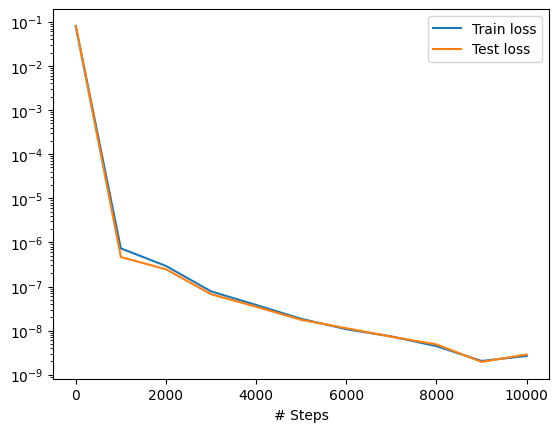

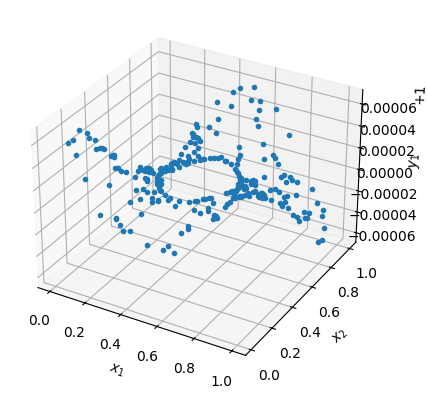

In [4]:
import deepxde as dde
import numpy as np
import matplotlib.pyplot as plt

D = 1.0
k = 0.1
alpha = 1.0

outer = dde.geometry.Rectangle(xmin=[0, 0], xmax=[1, 1])
inclusion = dde.geometry.Disk(center=[0.5, 0.5], radius=0.2)
fluid_domain = outer - inclusion

def robin_func(x, u):
    return -k * (alpha - u)

def boundary_solid(x, on_boundary):
    return on_boundary and inclusion.on_boundary(x)

robin_bc = dde.icbc.RobinBC(
    fluid_domain,
    func=robin_func,
    on_boundary=boundary_solid
)


def pde(x, u):
    d2u_dx2 = dde.grad.hessian(u, x, i=0, j=0)
    d2u_dy2 = dde.grad.hessian(u, x, i=1, j=1)
    return D * (d2u_dx2 + d2u_dy2)  # grad^2(u) = 0

data = dde.data.PDE(
    fluid_domain,
    pde,
    [robin_bc],
    num_domain=1000,
    num_boundary=100,
    solution=None,
    num_test=200,
)

net = dde.nn.FNN(
    [2] + [50] * 4 + [1],
    "tanh",
    "Glorot normal",
)

# 5. Model Compilation
model = dde.Model(data, net)
model.compile("adam", lr=0.001)


losshistory, train_state = model.train(
    iterations=10000,
)

dde.saveplot(losshistory, train_state, issave=True, isplot=True)

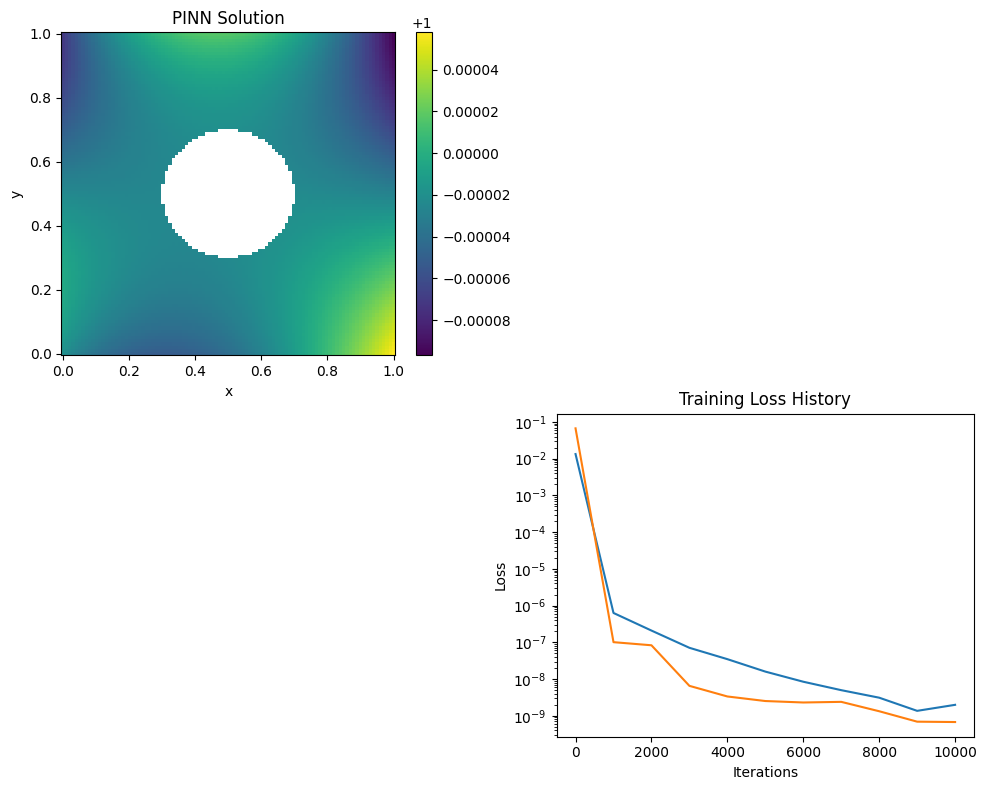

In [5]:
from scipy.sparse import diags
from scipy.sparse.linalg import spsolve

x = np.linspace(0, 1, 100)
y = np.linspace(0, 1, 100)
X, Y = np.meshgrid(x, y)
X_flat = X.flatten()[:, None]
Y_flat = Y.flatten()[:, None]
points = np.hstack((X_flat, Y_flat))

Z_pinn = model.predict(points)[:, 0].reshape(X.shape)

mask = (X - 0.5)**2 + (Y - 0.5)**2 <= 0.2**2
Z_pinn[mask] = np.nan

plt.figure(figsize=(10, 8))
plt.subplot(221)
im = plt.pcolormesh(X, Y, Z_pinn, shading='auto', cmap='viridis')
plt.colorbar(im)
plt.title('PINN Solution')
plt.xlabel('x')
plt.ylabel('y')

def fdm_solution(nx, ny, D, k, alpha):
    dx = 1.0 / (nx - 1)
    dy = 1.0 / (ny - 1)

    main_diag = -2 * (1/dx**2 + 1/dy**2) * np.ones(nx*ny)
    off_diag_x = 1/dx**2 * np.ones(nx*ny-1)
    off_diag_y = 1/dy**2 * np.ones(nx*ny-ny)

    A = diags([main_diag, off_diag_x, off_diag_x, off_diag_y, off_diag_y],
              [0, 1, -1, ny, -ny], format='csr')

    b = np.zeros(nx*ny)
    for i in range(nx):
        for j in range(ny):
            idx = i*ny + j
            x, y = i*dx, j*dy
            if (x-0.5)**2 + (y-0.5)**2 <= 0.2**2:
                A[idx, :] = 0
                A[idx, idx] = 1
                b[idx] = 0
            elif (x-0.5)**2 + (y-0.5)**2 <= 0.21**2:  # Boundary approx
                A[idx, idx] -= k/D
                b[idx] = -k*alpha/D

    u = spsolve(A, b)
    return u.reshape((nx, ny))
'''
Z_fdm = fdm_solution(100, 100, D, k, alpha)
Z_fdm[mask] = np.nan

plt.subplot(222)
im = plt.pcolormesh(X, Y, Z_fdm, shading='auto', cmap='viridis')
plt.colorbar(im)
plt.title('FDM Solution')
plt.xlabel('x')
plt.ylabel('y')

plt.subplot(223)
diff = Z_pinn - Z_fdm
im = plt.pcolormesh(X, Y, diff, shading='auto', cmap='RdBu', vmin=-0.1, vmax=0.1)
plt.colorbar(im)
plt.title('Difference (PINN - FDM)')
plt.xlabel('x')
plt.ylabel('y')
'''

plt.subplot(224)
plt.semilogy(losshistory.steps, losshistory.loss_train)
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('Training Loss History')

plt.tight_layout()
plt.show()